# genotyping using HMM

In [1]:
import numpy as np
import numpy.ma 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from snpmatch.core import parsers, genomes, genotype_cross, snp_genotype
import logging
log = logging.getLogger(__name__)

### provide input files

In [56]:
db_file = "/groups/nordborg/projects/field_experiments/007.pilot.sequencing/018.genotyping.by.plate/996.Swedes.220_6.newReSeq.July2020/002.mergeVCF/02_Swedes200_6.newReSeq_2.3M.BIALLELIC.hdf5"
input_vcf_file = "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/f2_batchthree.maf_filtered.vcf.gz"
parents = "6046x6191_reSeq"

In [237]:
genome = genomes.Genome("athaliana_tair10")
g = snp_genotype.load_genotype_files( db_file )
geno_cross = genotype_cross.GenotypeCross(g, parents )


g_chr_names = genome.chrs[pd.Series(geno_cross.commonSNPsCHR, dtype = str).apply(genome.get_chr_ind)]
snpvcf = parsers.import_vcf_file(inFile =  input_vcf_file , logDebug = False, samples_to_load = None)
samples_ids = pd.Series(snpvcf['samples']) 
samples_gt = snpvcf['gt']
samples_gt = pd.DataFrame(samples_gt.astype(str))
segregating_ix = geno_cross.g.get_common_positions( geno_cross.commonSNPsCHR, geno_cross.commonSNPsPOS, snpvcf['chr'], snpvcf['pos'] )
samples_gt = samples_gt.iloc[segregating_ix[1],:]

In [256]:
allSNPGenos_raw = pd.DataFrame( 
    index = pd.Series(geno_cross.commonSNPsCHR[segregating_ix[0]]).astype(str) + ":" + pd.Series(geno_cross.commonSNPsPOS[segregating_ix[0]]).astype(str),
    columns=samples_gt.columns
)
for ef in samples_gt.iteritems():
    allSNPGenos_raw.loc[:,ef[0]] = get_parental_obs(ef[1].values, geno_cross.snpsP1[segregating_ix[0]], geno_cross.snpsP2[segregating_ix[0]])
# 

In [330]:
def uniq_neighbor(a):
    sorted_a = np.array(a[0], dtype = a.dtype)
    sorted_a_count = np.array([1], dtype = int)
    for ef_ix in range(1, len(a)):
        if a[ef_ix] != a[ef_ix-1]:
            sorted_a = np.append(sorted_a, a[ef_ix])
            sorted_a_count = np.append(sorted_a_count, 1)
        elif a[ef_ix] == a[ef_ix-1]:
            sorted_a_count[-1] += 1
    return((sorted_a, sorted_a_count))
        
def get_parental_obs(input_gt, snpsP1_gt, snpsP2_gt, polarize = None):
    num_snps = len(input_gt)
    ebTarGTs = parsers.parseGT(input_gt)
    ebPolarised = np.zeros(num_snps, dtype=int)
    ### Here I am having 6 observed states. to consider SNPs where either of the parent shows -1 
    ## ('00', '01', '11',  'NA') ### removed '0', '1',
    ##    0,    1,    2,   3  ###  4,    5
    ebPolarised[:] = 3
    snpsP1_gt_mask = numpy.ma.masked_less(numpy.ma.masked_greater(snpsP1_gt, 1), 0)
    snpsP2_gt_mask = numpy.ma.masked_less(numpy.ma.masked_greater(snpsP2_gt, 1), 0)
    ebPolarised[np.where((np.equal( ebTarGTs, snpsP1_gt_mask )) & (~snpsP2_gt_mask) )[0] ] = 0  ## 00
    ## ebPolarised[np.where((np.equal( ebTarGTs, snpsP1_gt_mask )) & (snpsP2_gt_mask) )[0] ] = 3 ## 0
    ebPolarised[np.where((np.equal( ebTarGTs, snpsP2_gt_mask )) & (~snpsP1_gt_mask) )[0] ] = 2  ## 11
    ## ebPolarised[np.where((np.equal( ebTarGTs, snpsP2_gt_mask )) & (snpsP1_gt_mask) )[0] ] = 4 ## 1
    ebPolarised[np.where( np.equal( ebTarGTs, np.repeat(2, num_snps)) & (snpsP1_gt_mask != snpsP2_gt_mask ) )[0] ] = 1
#     & ( ~snpsP1_gt_mask ) & (~snpsP2_gt_mask)
    return(ebPolarised)

def init_hmm(num_markers, chromosome_size = 115, recomb_rate = 3.3, n_iter = 100):
    """
    Function to initilize a HMM model 
    Input: 
        number of markers
        recomb_rate: assumed rate of recombination (cM per Mb)
        genome_size: size of chromosome in Mb
    """
    from hmmlearn import hmm
    ### The below transition probability is for a intercross, adapted from R/qtl
    log.info("Initialising HMM")
    states = ('aa', 'ab', 'bb')
    observations = ('00', '01', '11', 'NA')
    ## assume A. thaliana genome size of 115 Mb 
    ## First calculate the average spacing between the markers
    ## chromosome_size / num_markers 
    ##_____
    ## given a recombination rate of ~3.3 
    # probability you see a recombinant is 1 / (100 * recomb_rate)
    prob_of_change = ( chromosome_size / num_markers ) * ( 1 / (100 * recomb_rate)  )
    transmission_prob = [
            [1 - prob_of_change,  prob_of_change/2,   prob_of_change/2],
            [prob_of_change/2,    1 - prob_of_change, prob_of_change/2],
            [prob_of_change/2,    prob_of_change/2,   1 - prob_of_change]
    ]
    ## We have 4 observed states, 00, 01, 11 and NA -- need an emmission matrix with shape 3x4
    # Check Rqtl book page 381. Emission probabilities for intercross given error probability
    ## Please modify emission probabilies based on your real data. 
    # 1. Check if you have SNP data on parents. Calculate the probability of observing each states (00, 01, 11 and NA). This would be the row 1 and 3 (symmetric) of emission probability matrix P(O|G = homo) 
    # 2. Check few individuals that looks like heterozygous on a given chromosome. Estimate the probabilies of each observed state in this region. This would be emission probability for P(O|G = hete)
    ## Make sure you check the centromeric and pericentromeric regions well.
    ## increase the probability a little on 01 and 11 given aa as underlying state
    # Once you have these probabilies -- change the scripts accordingly.
    emission_prob = [ 
        [0.163,  0.004,   0.003,   0.83], 
        [0.06, 0.03,   0.04,  0.87],
        [0.003,  0.002,   0.114,   0.75]
    ]
    model = hmm.MultinomialHMM(n_components=3, n_iter = n_iter, algorithm = "viterbi", init_params='st') 
    model.startprob_ = np.array([0.25, 0.5, 0.25])
    model.transmat_ = pd.DataFrame(transmission_prob)
    model.emissionprob_ = pd.DataFrame(emission_prob)
    return(model)

In [329]:
# 0.114 + 0.003 + 0.003 + 0.88

# 0.06 + 0.03 + 0.04 + 0.87

0.163 + 0.004 + 0.003 + 0.83

1.0

In [325]:
sample_ix = np.where(samples_ids.str.contains('P_6046'))[0]   ## ancestral state 0
# sample_ix = np.where(samples_ids.str.contains('P_6191'))[0]  ## ancestral state 1
# sample_ix = np.where(samples_ids.str.contains('F1'))[0]  #### Het


t_genotypes_raw = pd.Series(allSNPGenos_raw.iloc[:,sample_ix].values.flatten())
t_genotypes_raw.value_counts( normalize = True, sort = False )

0    0.166862
1    0.003729
2    0.003009
3    0.826401
dtype: float64

In [334]:
t_chr_ix = 1
sample_ix = 5

ec = genome.chrs[t_chr_ix] 
eclen = genome.chrlen[t_chr_ix]
reqChrind = np.where( g_chr_names[segregating_ix[0]] == ec )[0]

model = init_hmm( samples_gt.shape[0] )
# model = model.fit(t_genotypes_raw.reshape((-1, 1)),  )
t_genotypes_raw = allSNPGenos_raw.iloc[ reqChrind,sample_ix ].values
t_genotypes = model.decode(t_genotypes_raw.reshape((-1, 1)), algorithm='viterbi')

# uniq_neighbor( t_genotypes[1] )
print( "%s" % t_genotypes[0] )

-937.6691339916808


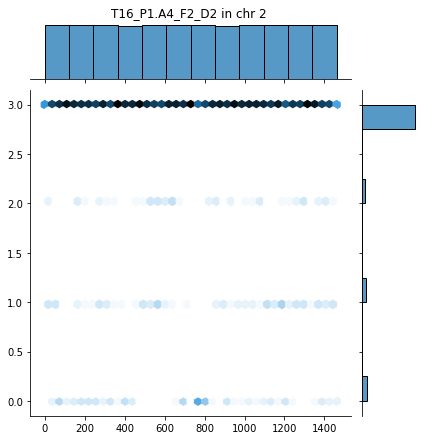

In [335]:
p = sns.jointplot(np.arange(t_genotypes_raw.shape[0]), t_genotypes_raw, kind="hex", joint_kws=dict(gridsize=40))


p.ax_marg_x.set_title( "%s in chr %s " % (samples_ids.values[sample_ix], ec) )
plt.show()

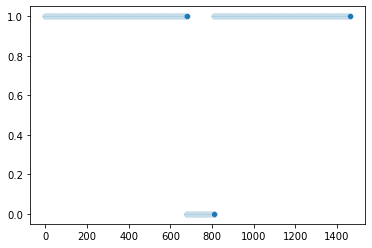

In [336]:
sns.scatterplot(np.arange(t_genotypes[1].shape[0]), t_genotypes[1] )